# MetOcean Solutions Observation API connector

Author: Sebastien Delaux

This notebook describes how to get observation data from one of MetOcean Solutions' observation API.

The data that can be accessed though the API come from different sources such as MetService's automatic weather station network, a number of wave buoys and tidal gages owned by various organisations. Different instances of the API are used for different sources. This connector should work for all of them.

The API provides the data as sets of records that belong to a station.
Each station is identified by a unique id string. Each station has its own metadata describing location, instrument, ownership, status, license and level of permission. If the station is not open then anyone interested to use the data needs to get in contact with MetOcean to negotiate access to the data. Any access to data non data will be done using the same connector but authentication will need to be set when initialising the connector.

For now the connector allows to retrieve data in the shape of xarray datasets.

A complete documentation of the API can be found here: https://observations-open.metoceanapi.com/api/swagger/


## Installation of required libraries

Install and import xarray and matplotlib in the current Jupyter kernel.
Xarray is a great library to work with data stored using NetCDF format. MetOcean's Observation API can provide data under the form of netCDF-like JSON and hence xarray is a great option to work with that data.
Matplotlib will used to plot the data.

In [1]:
import sys
!{sys.executable} -m pip install xarray matplotlib
import xarray

  Using cached https://files.pythonhosted.org/packages/ee/11/fb2a8a6015e3de4ff19a4870bb0d11f48ebdd997062557d24cd076b3088f/xarray-0.15.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/93/4b/52da6b1523d5139d04e02d9e26ceda6146b48f2a4e5d2abfdf1c7bac8c40/matplotlib-3.2.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/07/08/a549ba8b061005bb629b76adc000f3caaaf881028b963c2e18f811c6edc1/numpy-1.18.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/a0/df/635cdb901ee4a8a42ec68e480c49f85f4c59e8816effbf57d9e6ee8b3588/setuptools-46.1.3-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bb/71/8f53bdbcbc67c912b888b40def255767e475402e9df64050019149b1a943/pandas-1.0.3-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl
  Using cached ht

Install and import cf-json extension to xarray which will be used to turn netCDF-like json as returned by the API into an xarray Dataset

In [2]:
!{sys.executable} -m pip install git+ssh://git@github.com/metocean/cf-json@v0.3.3
from cfjson.xrdataset import CFJSONinterface

  Cloning ssh://git@github.com/metocean/cf-json (to v0.3.3) to /tmp/pip-ne5mykz6-build
  Running setup.py install for cfjson ... done


Import request library to query the API and path module of os package to help building url

In [3]:
import requests
from os import path

## Definition of connector

Declare a new exception class that can be used to identify any exception raised by the connector

In [4]:
class MetOceanObsAPIException(Exception):
    def __init__(self, message, obj=None, obj_name=None, status=400):
        self.message = message
        self.obj = obj
        self.obj_name = obj_name
        self.status = status
        super(ThreddsServerConnector, self).__init__(message)

Definition of connector

In [5]:
class MetOceanObsAPIConnector(object):
    """
    A class used to connect one of MetOcean Solution's instances
    of their observation API.
    
    Attributes
    ----------
    root_url : str
        The root url of the service
        
    Methods
    -------
    get_station_metadata(station_id)
        return the metadata associated with a given observation station
    get_data()
        return observation data retrieved from the API in the form of a xarray dataset object
    """
    
    def __init__(self,
                 root_url="https://observations-open.metoceanapi.com",
                 username=None, password=None, api_key=None):
        """
        Initialise the connector
        
        Parameters
        ----------
        root_url : str
            The url of the observation API to connect to. (default is https://observations-open.metoceanapi.com)
        username : str
            The username to use to connect the API
        password : str
            The password to use to connect the API
        api_key : str
            The api_key to use to connect the API
                
        Raises
        ------
        NotImplementedError
            If any of the authentication parameters is set.
        """
    
        self.root_url = path.join(root_url, 'api/stations')
        
        if username or password or api_key:
            raise NotImplementedError("Secure authentication is yet to be implemented for the connector")
    
        
    def get_station_metadata(self, station_id):
        """
        Get the metadata associated with a given observation station
        
        Parameters
        ----------
        station_id : str
            The id of the station to return the metadata for.
            
        Raises
        ------
        MetOceanObsAPIException
            If query did not return with 200 status code
            
        Returns
        -------
        dict
            A dictionary containing the metadata associated with the station
        
        """
        
        # Build query url
        url = path.join(self.root_url,
                        station_id)
        
        # Do request
        res = requests.get(url)
        
        # Check request successed. If not raise exception
        if res.status_code != 200:
            raise MetOceanObsAPIException("getstation_metadata query failed with status code {1} and reasons: %s"\
                                          .format(res.status_code,\
                                                  res.text))
        
        # Decode JSON response and return
        return res.json()
            
    def get_data(self,
                 station_id,
                 time=None,
                 variables=None,
                 max_nrecords=100):
        """
        Get the metadata associated with a given observation station
        
        Parameters
        ----------
        station_id : str
            The id of the station to return the metadata for.
        time : str
            ISO8601 time interval with double dash option and empty start/end allowed
            used to filter the data. Valid exemples are:
                time=2007-03-01T13:00:00Z--2008-05-11T15:30:00Z
                time=2007-03-01T13:00:00Z--
                time=--2008-05-11T15:30:00Z
        variables : list
            List of strings containing the name of the variables to retrieve.
            Return all by default
        max_nrecords : int
            The maximum number of records to retrieve (default is 100)
            
        Raises
        ------
        MetOceanObsAPIException
            If query did not return with 200 status code
            
        Returns
        -------
        xarray dataset
            A xarray dataset containing the data for the station
        
        """
        
        # Build full url to query records
        url = path.join(self.root_url,
                        station_id,
                        'records')
        
        # Build dictionary with query parameters
        params = {}
        params['time'] = time
        params['vars'] = variables
        params['limit'] = max_nrecords
        
        # Excecute request
        res = requests.get(url,
                           headers={'accept': 'application/vnd.metocean.cf+json'},
                           params=params)
        
        # Check for success
        if res.status_code != 200:
            raise MetOceanObsAPIException("Get data query failed with status code {1} and reasons: %s"\
                                          .format(res.status_code,\
                                                  res.text))
        
        # Turn data into xarray dataset
        dset = xarray.Dataset()
        dset.cfjson.from_json(res.json())
        
        # Return xarray dataset
        return dset

Instantiate new connector and retrieve metadata for the station of id 'ciwrb'

In [6]:
obs_api_connector = MetOceanObsAPIConnector()

metadata = obs_api_connector.get_station_metadata(station_id='ciwrb')
                                  
print(metadata)

{'id': 'ciwrb', 'name': 'ciwrb', 'tags': ['wave'], 'description': '', 'provider': 'metocean', 'level': 0.0, 'dataset': 'socean', 'coordinates': 'POINT (169.04916 -52.76000000000001)', 'latitude': -52.76000000000001, 'longitude': 169.04915999999997, 'public': True, 'is_active': False, 'last_record_at': '2019-06-19T18:00:00Z'}


For now the metadata available is limited and some metadata like the variables provided for a given station are not available. That information can be retrieved by first querying for a sample of the data.

In [7]:
dset = obs_api_connector.get_data(station_id='ciwrb',
                                  max_nrecords=3)

From the sample result, the names of the variables can be listed:

In [8]:
for (var_name, var) in dset.data_vars.items():
    print(var.attrs['standard_name'],'-->', var_name)

latitude --> latitude
longitude --> longitude
altitude --> level
sea_surface_wave_period_at_variance_spectral_density_maximum --> tp
sea_surface_wave_significant_height --> hs
sea_surface_wave_maximum_height --> hmax
sea_surface_wave_from_direction_at_variance_spectral_density_maximum --> dpm


Now we can query for specific variables only and a set time range

In [9]:
dset = obs_api_connector.get_data(station_id='ciwrb',
                                  time='2019-06-18T15:00:00Z--2019-06-19T21:00:00Z',
                                  variables=['hs', 'tp'],
                                  max_nrecords=300)
print("Retrieved {0} records for station ciwrb".format(len(dset.time)))

Retrieved 9 records for station ciwrb


Now we can do the same for a weather station. We retrieve temperature (tmp) since 2020-01-21 19:00:00Z and we get at most 200 records

In [10]:
dset = obs_api_connector.get_data(station_id='tu0fknyk',
                                  time=['2020-01-21 19:00:00Z--'],
                                  max_nrecords=200)

print("Retrieved {0} records for station tu0fknyk".format(len(dset.time)))

Retrieved 200 records for station tu0fknyk


Now lets plot the data using matplotlib

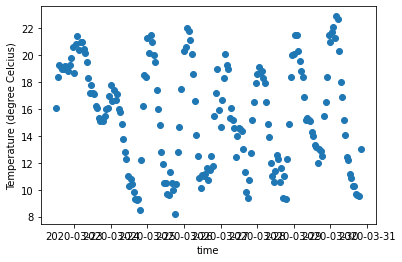

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

plt.xlabel('time')
plt.ylabel('Temperature (degree Celcius)')
plt.plot_date(date2num(dset.time), dset.tmp.data)

## Simple numerical data correction example

Now we are going to put together a toy example aiming at correcting numerical data using observation data. That kind of approach could be used in the context of statistical downscaling.

Note that this is a toy example aimed at demonstrating a workflow and one added constraint for the demonstration was that it had to use a neural network model.

The amount of data used here is tiny and clearly not enough to build something scientifically robust. Also the model is only suitable in that it is aimed at working on sequences of data, we did not investigate scientific suitability and it is likely there are simpler and more suitable options. 

The data used here is the 2 metres temperature from the nowcast for the last 9 days from the 0.25 degree GFS model at the same location as that of the observation station tu0fknyk.

In [12]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np

Here is a useful function that converts the datetime format used by xarray to the "standard" python datetimes.

In [13]:
def datetime64_to_datetime(dd):
    return datetime.utcfromtimestamp(round(dd.data.astype(int) * 1e-9))

Get the longitude/latitude coordinates of the observation point

In [14]:
lon0 = dset.longitude.data[0]
lat0 = dset.latitude.data[0]

Now load one of the GFS dataset to identify the nearest grid point to the observation station

In [76]:
now = datetime.utcnow()
gfs = xarray.open_dataset('https://nomads.ncep.noaa.gov:9090/dods/gfs_0p25_1hr/gfs%04d%02d%02d/gfs_0p25_1hr_00z'%(now.year, now.month, now.day))

In [77]:
ilon = np.argmin(np.abs(gfs.lon.data-lon0))
ilat = np.argmin(np.abs(gfs.lat.data-lat0))
print("Approximating longitude",lon0,"by",gfs.lon.data[ilon])
print("Approximating latitude",lat0,"by",gfs.lat.data[ilat])
print(ilon, ilat)

Approximating longitude 174.971 by 175.0
Approximating latitude -37.03 by -37.0
700 212


For the last 9 days, download all forecast guidances (cycles 0,6,12 and 18) available and keep the 2 metre temperature variable at the point of interest for the first 6 hours (nowcast).

In [18]:
now = datetime.utcnow()
t = datetime(now.year, now.month, now.day) - relativedelta(days=9)
data = []
files = []
while t < now:
    for cycle in [0,6,12,18]:
        try:
            gfs = xarray.open_dataset('https://nomads.ncep.noaa.gov:9090/dods/gfs_0p25_1hr/gfs%04d%02d%02d/gfs_0p25_1hr_%02dz'%(t.year,t.month,t.day,cycle))
            print(gfs.time[0].data)
            files.append(gfs)
            data.append(gfs.tmp2m[:6,ilat,ilon])
            
        except:
            pass
    t = t + relativedelta(days=1)

2020-03-21T00:00:00.000000000
2020-03-21T06:00:00.000000000
2020-03-21T12:00:00.000000000
2020-03-21T18:00:00.000000000
2020-03-22T00:00:00.000000000
2020-03-22T06:00:00.000000000
2020-03-22T12:00:00.000000000
2020-03-22T18:00:00.000000000
2020-03-23T00:00:00.000000000
2020-03-23T06:00:00.000000000
2020-03-23T12:00:00.000000000
2020-03-23T18:00:00.000000000
2020-03-24T00:00:00.000000000
2020-03-24T06:00:00.000000000
2020-03-24T12:00:00.000000000
2020-03-24T18:00:00.000000000
2020-03-25T00:00:00.000000000
2020-03-25T06:00:00.000000000
2020-03-25T12:00:00.000000000
2020-03-25T18:00:00.000000000
2020-03-26T00:00:00.000000000
2020-03-26T06:00:00.000000000
2020-03-26T12:00:00.000000000
2020-03-26T18:00:00.000000000
2020-03-27T00:00:00.000000000
2020-03-27T06:00:00.000000000
2020-03-27T12:00:00.000000000
2020-03-27T18:00:00.000000000
2020-03-28T00:00:00.000000000
2020-03-28T06:00:00.000000000
2020-03-28T12:00:00.000000000
2020-03-28T18:00:00.000000000
2020-03-29T00:00:00.000000000
2020-03-29

Concatenate all the 6 hours segments into a single one

In [19]:
nowcast = xarray.concat(data,dim='time')

Now we get all the observation available since the start of the nowcast

In [20]:
t0 = datetime64_to_datetime(nowcast.time[0])
obs = obs_api_connector.get_data(station_id='tu0fknyk',
                                 time=['%04d-%02d-%02d %02d:00:00Z--'%(t0.year, t0.month, t0.day, t0.hour)],
                                 max_nrecords=1000)

As the observation API returns the most recent recoords first, we sort them by ascending time.

In [21]:
obs = obs.sortby('time', ascending=True)

Now we match the data. For each observation that has a corresponding time-stamp in the nowcast put data keep the data.

In [22]:
obs_data = []
nowcast_data = []
time = []

# Parse datetime for nowcast
nowcast_time = np.array([datetime64_to_datetime(t) for t in nowcast.time])

for it, t in enumerate(obs.time[:]):
    # Check if match
    match = np.where(nowcast_time == datetime64_to_datetime(t))
    if len(match[0]) == 1:
        obs_data.append(obs.tmp.data[it])
        nowcast_data.append(nowcast[match[0]].data[0])
            
        time.append(datetime64_to_datetime(t))

# Turn list into numpy array (nicer to work with)
obs_data =  np.array(obs_data)
# Do also conversion from Kelvin to Celcius
nowcast_data = np.array(nowcast_data)-273.18
time = np.array(time)

Now let's plot the retrieved data. There does not seem to be much if any bias but it looks like the amplitude of the daily variations in the observations is slightly larger than that of the nowcast data so maybe we can correct for that.

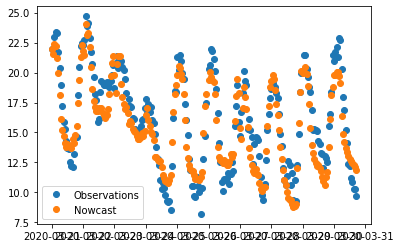

In [23]:
%matplotlib inline

plt.plot_date(date2num(time), obs_data, label='Observations')
plt.plot_date(date2num(time), nowcast_data, label='Nowcast')
plt.legend()

We will have a go at using a simple LSTM model built using Keras with a tensorflow backend.
We assume that the image/environment we use here already has CUDA/CUDNN/Tensorflow installed.
We just add Keras.

In [28]:
!{sys.executable} -m pip install keras

  Using cached https://files.pythonhosted.org/packages/ad/fd/6bfe87920d7f4fd475acd28500a42482b6b84479832bdc0fe9e589a60ceb/Keras-2.3.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/60/06/cafdd44889200e5438b897388f3075b52a8ef01f28a17366d91de0fa2d05/h5py-2.10.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/28/6a/8c1f62c37212d9fc441a7e26736df51ce6f0e38455816445471f10da4f0a/Keras_Preprocessing-1.1.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/65/eb/1f97cb97bfc2390a276969c6fae16075da282f5058082d4cb10c6c5c1dba/six-1.14.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/dc/29/162476fd44203116e7980cfbd9352eef9db37c49445d1fec35509022f6aa/scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/07/08/a549ba8b061005bb629b76adc000f3caaaf881028b963c2e18f811c6edc1/numpy-1.18.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https

First we prepare the data to model. We will use sequences of the 15 consecutive nowcast points and attempt at predicting the difference between the observations and the nowcast.

In [24]:
x = np.array([nowcast_data[i:i+15] for i in range(len(nowcast_data)-15)])
y = np.array([obs_data[i:i+15][-1]-nowcast_data[i:i+15][-1] for i in range(len(obs_data)-15)])

# Needs to be of shape (nsamples, sequence_length, nfeatures)
x = x.reshape(x.shape[0], x.shape[1], 1)

We normalise the input data to the neural network

In [27]:
xmin = x.min()
xmax = x.max()
x = (x-xmin)/(xmax-xmin)
print(xmin, xmax)

8.8012085 24.061737


Now we load leras and build the model

In [67]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input

neurons = 10
batch_size = 32
nb_epoch = 1000

In [68]:
ip = Input((x.shape[1], x.shape[2]))
xx = LSTM(neurons, stateful=False)(ip)
out = Dense(1)(xx)
model = Model(ip, out)

model.compile(loss='mean_squared_error', optimizer='adam')

We train the model on all data except for the last 50 samples

In [69]:
model.fit(x[:-50], y[:-50], epochs=nb_epoch, batch_size=batch_size, verbose=1, shuffle=False)

Epoch 1/1000
168/168 [==============================] - 0s 2ms/step - loss: 2.5169
Epoch 2/1000
168/168 [==============================] - 0s 114us/step - loss: 2.4623
Epoch 3/1000
168/168 [==============================] - 0s 115us/step - loss: 2.4153
Epoch 4/1000
168/168 [==============================] - 0s 125us/step - loss: 2.3740
Epoch 5/1000
168/168 [==============================] - 0s 101us/step - loss: 2.3374
Epoch 6/1000
168/168 [==============================] - 0s 138us/step - loss: 2.3045
Epoch 7/1000
168/168 [==============================] - 0s 111us/step - loss: 2.2747
Epoch 8/1000
168/168 [==============================] - 0s 130us/step - loss: 2.2474
Epoch 9/1000
168/168 [==============================] - 0s 116us/step - loss: 2.2220
Epoch 10/1000
168/168 [==============================] - 0s 108us/step - loss: 2.1983
Epoch 11/1000
168/168 [==============================] - 0s 107us/step - loss: 2.1762
Epoch 12/1000
168/168 [==============================] - 0s 108us

168/168 [==============================] - 0s 110us/step - loss: 1.7400
Epoch 97/1000
168/168 [==============================] - 0s 106us/step - loss: 1.7376
Epoch 98/1000
168/168 [==============================] - 0s 120us/step - loss: 1.7351
Epoch 99/1000
168/168 [==============================] - 0s 102us/step - loss: 1.7327
Epoch 100/1000
168/168 [==============================] - 0s 100us/step - loss: 1.7302
Epoch 101/1000
168/168 [==============================] - 0s 111us/step - loss: 1.7276
Epoch 102/1000
168/168 [==============================] - 0s 118us/step - loss: 1.7251
Epoch 103/1000
168/168 [==============================] - 0s 104us/step - loss: 1.7225
Epoch 104/1000
168/168 [==============================] - 0s 108us/step - loss: 1.7199
Epoch 105/1000
168/168 [==============================] - 0s 107us/step - loss: 1.7173
Epoch 106/1000
168/168 [==============================] - 0s 109us/step - loss: 1.7146
Epoch 107/1000
168/168 [==============================] - 0s 

168/168 [==============================] - 0s 113us/step - loss: 1.4754
Epoch 191/1000
168/168 [==============================] - 0s 106us/step - loss: 1.4737
Epoch 192/1000
168/168 [==============================] - 0s 102us/step - loss: 1.4720
Epoch 193/1000
168/168 [==============================] - 0s 120us/step - loss: 1.4703
Epoch 194/1000
168/168 [==============================] - 0s 109us/step - loss: 1.4687
Epoch 195/1000
168/168 [==============================] - 0s 99us/step - loss: 1.4670
Epoch 196/1000
168/168 [==============================] - 0s 122us/step - loss: 1.4653
Epoch 197/1000
168/168 [==============================] - 0s 106us/step - loss: 1.4636
Epoch 198/1000
168/168 [==============================] - 0s 100us/step - loss: 1.4619
Epoch 199/1000
168/168 [==============================] - 0s 114us/step - loss: 1.4602
Epoch 200/1000
168/168 [==============================] - 0s 98us/step - loss: 1.4585
Epoch 201/1000
168/168 [==============================] - 0s

168/168 [==============================] - 0s 126us/step - loss: 1.2777
Epoch 285/1000
168/168 [==============================] - 0s 113us/step - loss: 1.2753
Epoch 286/1000
168/168 [==============================] - 0s 112us/step - loss: 1.2729
Epoch 287/1000
168/168 [==============================] - 0s 115us/step - loss: 1.2705
Epoch 288/1000
168/168 [==============================] - 0s 103us/step - loss: 1.2681
Epoch 289/1000
168/168 [==============================] - 0s 105us/step - loss: 1.2657
Epoch 290/1000
168/168 [==============================] - 0s 101us/step - loss: 1.2633
Epoch 291/1000
168/168 [==============================] - 0s 120us/step - loss: 1.2609
Epoch 292/1000
168/168 [==============================] - 0s 117us/step - loss: 1.2585
Epoch 293/1000
168/168 [==============================] - 0s 103us/step - loss: 1.2561
Epoch 294/1000
168/168 [==============================] - 0s 111us/step - loss: 1.2537
Epoch 295/1000
168/168 [==============================] - 

168/168 [==============================] - 0s 108us/step - loss: 1.0692
Epoch 379/1000
168/168 [==============================] - 0s 134us/step - loss: 1.0672
Epoch 380/1000
168/168 [==============================] - 0s 137us/step - loss: 1.0653
Epoch 381/1000
168/168 [==============================] - 0s 105us/step - loss: 1.0633
Epoch 382/1000
168/168 [==============================] - 0s 106us/step - loss: 1.0613
Epoch 383/1000
168/168 [==============================] - 0s 106us/step - loss: 1.0594
Epoch 384/1000
168/168 [==============================] - 0s 100us/step - loss: 1.0574
Epoch 385/1000
168/168 [==============================] - 0s 110us/step - loss: 1.0555
Epoch 386/1000
168/168 [==============================] - 0s 105us/step - loss: 1.0536
Epoch 387/1000
168/168 [==============================] - 0s 102us/step - loss: 1.0516
Epoch 388/1000
168/168 [==============================] - 0s 113us/step - loss: 1.0497
Epoch 389/1000
168/168 [==============================] - 

168/168 [==============================] - 0s 104us/step - loss: 0.9062
Epoch 473/1000
168/168 [==============================] - 0s 121us/step - loss: 0.9047
Epoch 474/1000
168/168 [==============================] - 0s 102us/step - loss: 0.9033
Epoch 475/1000
168/168 [==============================] - 0s 109us/step - loss: 0.9019
Epoch 476/1000
168/168 [==============================] - 0s 104us/step - loss: 0.9005
Epoch 477/1000
168/168 [==============================] - 0s 105us/step - loss: 0.8991
Epoch 478/1000
168/168 [==============================] - 0s 99us/step - loss: 0.8978
Epoch 479/1000
168/168 [==============================] - 0s 131us/step - loss: 0.8964
Epoch 480/1000
168/168 [==============================] - 0s 101us/step - loss: 0.8951
Epoch 481/1000
168/168 [==============================] - 0s 115us/step - loss: 0.8937
Epoch 482/1000
168/168 [==============================] - 0s 115us/step - loss: 0.8924
Epoch 483/1000
168/168 [==============================] - 0

168/168 [==============================] - 0s 123us/step - loss: 0.8411
Epoch 567/1000
168/168 [==============================] - 0s 147us/step - loss: 0.8086
Epoch 568/1000
168/168 [==============================] - 0s 103us/step - loss: 0.8525
Epoch 569/1000
168/168 [==============================] - 0s 102us/step - loss: 0.8163
Epoch 570/1000
168/168 [==============================] - 0s 97us/step - loss: 0.8654
Epoch 571/1000
168/168 [==============================] - 0s 115us/step - loss: 0.8265
Epoch 572/1000
168/168 [==============================] - 0s 106us/step - loss: 0.8723
Epoch 573/1000
168/168 [==============================] - 0s 105us/step - loss: 0.8312
Epoch 574/1000
168/168 [==============================] - 0s 125us/step - loss: 0.8654
Epoch 575/1000
168/168 [==============================] - 0s 129us/step - loss: 0.8240
Epoch 576/1000
168/168 [==============================] - 0s 100us/step - loss: 0.8481
Epoch 577/1000
168/168 [==============================] - 0

168/168 [==============================] - 0s 96us/step - loss: 0.7623
Epoch 661/1000
168/168 [==============================] - 0s 136us/step - loss: 0.7508
Epoch 662/1000
168/168 [==============================] - 0s 102us/step - loss: 0.7606
Epoch 663/1000
168/168 [==============================] - 0s 127us/step - loss: 0.7492
Epoch 664/1000
168/168 [==============================] - 0s 106us/step - loss: 0.7614
Epoch 665/1000
168/168 [==============================] - 0s 100us/step - loss: 0.7490
Epoch 666/1000
168/168 [==============================] - 0s 120us/step - loss: 0.7647
Epoch 667/1000
168/168 [==============================] - 0s 104us/step - loss: 0.7509
Epoch 668/1000
168/168 [==============================] - 0s 103us/step - loss: 0.7713
Epoch 669/1000
168/168 [==============================] - 0s 102us/step - loss: 0.7566
Epoch 670/1000
168/168 [==============================] - 0s 104us/step - loss: 0.7818
Epoch 671/1000
168/168 [==============================] - 0

168/168 [==============================] - 0s 101us/step - loss: 0.7193
Epoch 755/1000
168/168 [==============================] - 0s 106us/step - loss: 0.7145
Epoch 756/1000
168/168 [==============================] - 0s 117us/step - loss: 0.7122
Epoch 757/1000
168/168 [==============================] - 0s 104us/step - loss: 0.7113
Epoch 758/1000
168/168 [==============================] - 0s 110us/step - loss: 0.7099
Epoch 759/1000
168/168 [==============================] - 0s 124us/step - loss: 0.7100
Epoch 760/1000
168/168 [==============================] - 0s 112us/step - loss: 0.7085
Epoch 761/1000
168/168 [==============================] - 0s 123us/step - loss: 0.7092
Epoch 762/1000
168/168 [==============================] - 0s 114us/step - loss: 0.7071
Epoch 763/1000
168/168 [==============================] - 0s 117us/step - loss: 0.7086
Epoch 764/1000
168/168 [==============================] - 0s 100us/step - loss: 0.7057
Epoch 765/1000
168/168 [==============================] - 

168/168 [==============================] - 0s 105us/step - loss: 0.6792
Epoch 849/1000
168/168 [==============================] - 0s 108us/step - loss: 0.6779
Epoch 850/1000
168/168 [==============================] - 0s 99us/step - loss: 0.6777
Epoch 851/1000
168/168 [==============================] - 0s 104us/step - loss: 0.6765
Epoch 852/1000
168/168 [==============================] - 0s 97us/step - loss: 0.6766
Epoch 853/1000
168/168 [==============================] - 0s 101us/step - loss: 0.6751
Epoch 854/1000
168/168 [==============================] - 0s 117us/step - loss: 0.6758
Epoch 855/1000
168/168 [==============================] - 0s 144us/step - loss: 0.6737
Epoch 856/1000
168/168 [==============================] - 0s 106us/step - loss: 0.6758
Epoch 857/1000
168/168 [==============================] - 0s 102us/step - loss: 0.6728
Epoch 858/1000
168/168 [==============================] - 0s 107us/step - loss: 0.6780
Epoch 859/1000
168/168 [==============================] - 0s

168/168 [==============================] - 0s 115us/step - loss: 0.6572
Epoch 943/1000
168/168 [==============================] - 0s 100us/step - loss: 0.6678
Epoch 944/1000
168/168 [==============================] - 0s 106us/step - loss: 0.6758
Epoch 945/1000
168/168 [==============================] - 0s 109us/step - loss: 0.6919
Epoch 946/1000
168/168 [==============================] - 0s 96us/step - loss: 0.7173
Epoch 947/1000
168/168 [==============================] - 0s 101us/step - loss: 0.7280
Epoch 948/1000
168/168 [==============================] - 0s 110us/step - loss: 0.7576
Epoch 949/1000
168/168 [==============================] - 0s 97us/step - loss: 0.7314
Epoch 950/1000
168/168 [==============================] - 0s 94us/step - loss: 0.7343
Epoch 951/1000
168/168 [==============================] - 0s 184us/step - loss: 0.6886
Epoch 952/1000
168/168 [==============================] - 0s 145us/step - loss: 0.6755
Epoch 953/1000
168/168 [==============================] - 0s 

We evaluate the model on all data

In [70]:
res = model.predict(x).squeeze()

Plotting the data, the model fits the data OK but performs a lot less well on the last 50 time steps which were not in the training set

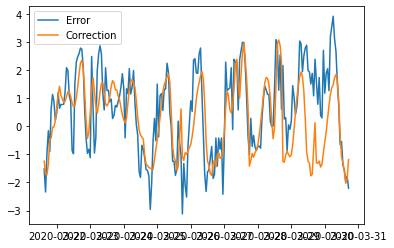

In [71]:
plt.plot(time[15:], obs_data[15:] - nowcast_data[15:], label='Error')
plt.plot(time[15:], res, label='Correction')
plt.legend()

Just for illustration here are the data and the corrected data. The results are not great which is not a surprise but the workflow is there.

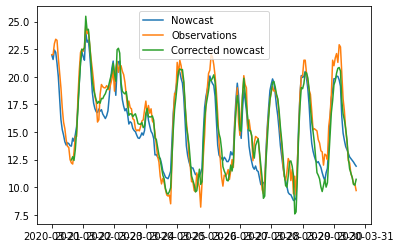

In [73]:
plt.plot(time, nowcast_data, label='Nowcast')
plt.plot(time, obs_data, label='Observations')
plt.plot(time[15:], res+nowcast_data[15:], label='Corrected nowcast')
plt.legend()